# General

## Introduction

Notebook containing **software-control** EEG processing pipeline. Goal is a general purpose discrimination system for EEG data, ie. the ability to classify sample EEG traces to a few given categories.

*Authors: Dasheng Bi*

## Quick Operations

In [3]:
# Libraries for data import, preprocessing
import numpy as np
import pandas as pd

# Visualization, clustering
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Path properties
train_root = 'csv_sa_2/'
test_root = 'csv_sa_2/'
prefix = 'db-rec-'
label = ['GO_', 'STOP_']
train_number = range(1, 4)
# test_number = range(3, 4)
suffix = '.csv'

# Data properties
SAMPLE_FREQ = 256
INTERVAL = 0.4
# N_COMPONENTS = 4 # raw data
N_COMPONENTS = 20 # filtered DTABG components
TRAIN_SAMPLES = 60
TEST_SAMPLES = 36

########################################################################

# Audio
from scipy.io import wavfile
from scipy import signal

# Audio Path Properties
audio_root = 'sound_2/'
audio_prefix = ''
audio_suffix = '.wav'

# Audio Data Properties
AUDIO_SAMPLE_FREQ = 44100
AUDIO_EVENT_THRESHOLD_LO = 1
AUDIO_EVENT_THRESHOLD_HI = 1000
MIN_AUDIO_EVENT_LENGTH = 10000

########################################################################
# A note on labels: 1 is "go," 0 is "stop."

# Data Loading, Preprocessing

## Imports

In [ ]:
# Libraries for data import, preprocessing
import numpy as np
import pandas as pd

In [ ]:
# Visualization, clustering
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

## Path Configuration

In [ ]:
# Path properties
root = 'csv1/'
prefix = 'db-rec-'
label = ['GO_', 'STOP_']
number = range(1, 6)
suffix = '.csv'

## Read Data, Select Columns

### General Attributes

In [ ]:
SAMPLE_FREQ = 256
INTERVAL = 0.5

# N_COMPONENTS = 4 # raw data
N_COMPONENTS = 20 # filtered DTABG components

TRAIN_SAMPLES = 60
TEST_SAMPLES = 8

### Explore Data Format

In [ ]:
path = root + prefix + label[0] + str(number[0]) + suffix
df = pd.read_csv(path)
print(df.columns)
df = df.drop(columns=df.columns[21:])
print(df.columns)
df = df.drop(columns=df.columns[0])
print(df.columns)
print(df.shape)

### Read in Training Data

In [ ]:
data_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
# print(data_stack)
# print(data_stack.shape)
for l in label:
    for trial in train_number:
        path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.

        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
    #         print(np.argwhere(np.isnan(raw_vals)))
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
#         print(data_stack.shape)
df_stack = pd.DataFrame(data_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

# Labels
train_labels = [1] * TRAIN_SAMPLES + [0] * TRAIN_SAMPLES

### Read in Testing Data

In [ ]:
test_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
for l in label:
    for trial in test_number:
        path = test_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
            test_stack = np.concatenate((test_stack, raw_vals), axis=0)
#             print(test_stack.shape)
df_test = pd.DataFrame(test_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("test_stack shape: ", test_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(test_stack))) == 0)  # Should be empty

# Labels
test_labels = [1] * TEST_SAMPLES + [0] * TEST_SAMPLES

## t-SNE Clustering of Samples

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.068s...
[t-SNE] Computed neighbors for 392 samples in 0.439s...
[t-SNE] Computed conditional probabilities for sample 392 / 392
[t-SNE] Mean sigma: 4.563027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.286125
[t-SNE] KL divergence after 950 iterations: 0.735337


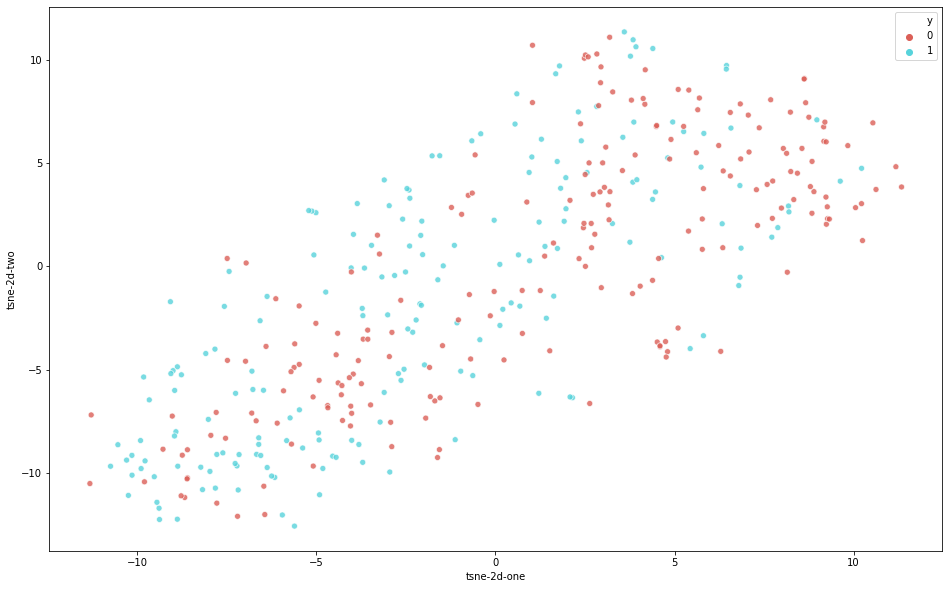

In [14]:
# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_columns)

tsne_df = pd.DataFrame()

# Plot
tsne_df['tsne-2d-one'] = tsne_results[:, 0]
tsne_df['tsne-2d-two'] = tsne_results[:, 1]
# Labels
y = [1] * NUM_SAMPLES[0] + [0] * NUM_SAMPLES[1]
tsne_df['y'] = y
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.8
)

### Playground: Multiple t-SNEs

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.069s...
[t-SNE] Computed neighbors for 392 samples in 0.405s...
[t-SNE] Computed conditional probabilities for sample 392 / 392
[t-SNE] Mean sigma: 3.086007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.921356
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.094s...
[t-SNE] Computed neighbors for 392 samples in 0.513s...
[t-SNE] Computed conditional probabilities for sample 392 / 392
[t-SNE] Mean sigma: 3.616160
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.431206
[t-SNE] KL divergen

[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.008949
[t-SNE] KL divergence after 800 iterations: 0.741378
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.095s...
[t-SNE] Computed neighbors for 392 samples in 0.468s...
[t-SNE] Computed conditional probabilities for sample 392 / 392
[t-SNE] Mean sigma: 4.563027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.442215
[t-SNE] KL divergence after 800 iterations: 0.683870
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.095s...
[t-SNE] Computed neighbors for 392 samples in 0.509s...
[t-SNE] Computed conditional probabilities for sample 392 / 392
[t-SNE] Mean sigma: 3.086007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.356140
[t-SNE] KL divergence after 1250 iterations: 1.062723
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 392 samples in 0.084s...
[t-SNE] Computed neighbors for 392 samples in 0.557s...
[t

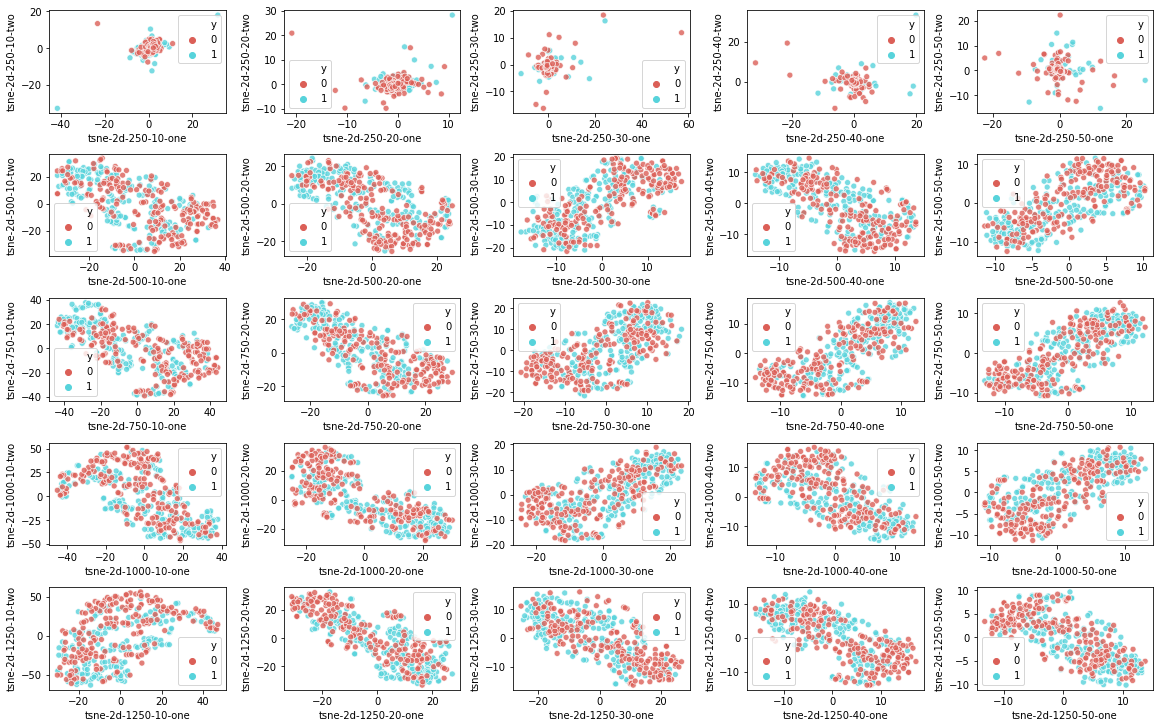

In [15]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)

for niter in range(250, 1500, 250):
    for perp in range(10, 55, 10):
        # multiple t-SNEs
        tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=niter)
        tsne_results = tsne.fit_transform(df_columns)
        
        tsne_df = pd.DataFrame()
        
        coord_prefix = 'tsne-2d-'
        coord_desc = str(niter) + '-' + str(perp)
        x_coord = coord_prefix + coord_desc + '-one'
        y_coord = coord_prefix + coord_desc + '-two'
        tsne_df[x_coord] = tsne_results[:, 0]
        tsne_df[y_coord] = tsne_results[:, 1]

        # Labels
        y = [1] * NUM_SAMPLES[0] + [0] * NUM_SAMPLES[1]
        tsne_df['y'] = y

        niter_offset = int((niter-250)/250)
        perp_offset = int((perp-10)/10)
        fig.add_subplot(spec[niter_offset, perp_offset])
        sns.scatterplot(
            x=x_coord, y=y_coord,
            hue="y",
            palette=sns.color_palette("hls", 2),
            data=tsne_df,
            legend="full",
            alpha=0.8,
        )

## PCA Clustering of Samples

Explained variation per principal component: [4.40720075e-01 1.60504668e-01 5.87034809e-02 5.40695489e-02
 4.15083824e-02 3.65698198e-02 3.12280407e-02 2.58989333e-02
 1.84374818e-02 1.59210113e-02 1.43420721e-02 1.30043157e-02
 1.22203407e-02 1.07931553e-02 8.17011662e-03 7.46623853e-03
 7.28160191e-03 6.10288703e-03 5.23714896e-03 4.74266922e-03
 3.95137452e-03 3.63649998e-03 2.62515912e-03 1.63364506e-03
 1.47512221e-03 1.27178778e-03 1.10283329e-03 8.74924180e-04
 8.29997937e-04 7.26017150e-04 6.28382829e-04 5.59015068e-04
 5.40659533e-04 4.75644451e-04 4.38971141e-04 3.78077511e-04
 3.65985723e-04 3.25049010e-04 3.00601875e-04 2.63204847e-04
 2.51514861e-04 2.37448614e-04 2.17183896e-04 2.04493926e-04
 1.88232023e-04 1.80839605e-04 1.62132167e-04 1.54731842e-04
 1.50643566e-04 1.38371634e-04]
Sum: 0.9972105328879382


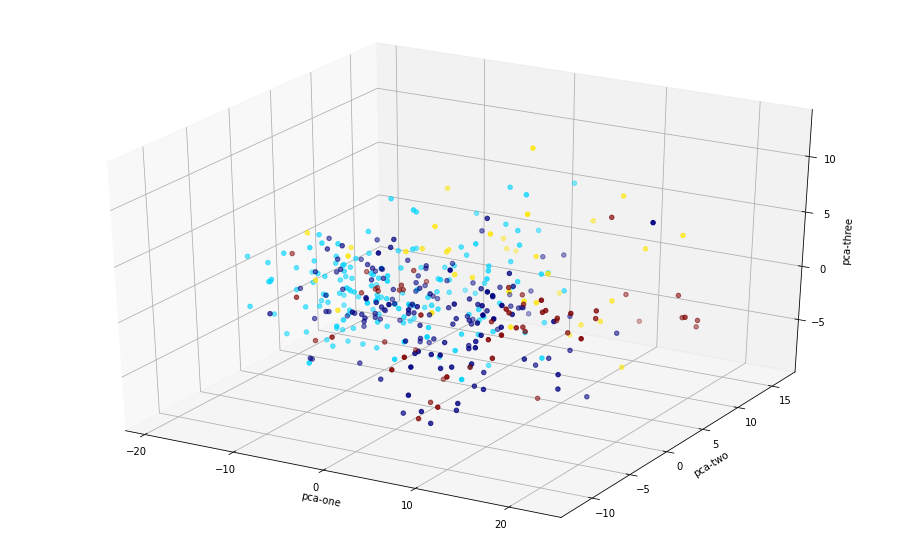

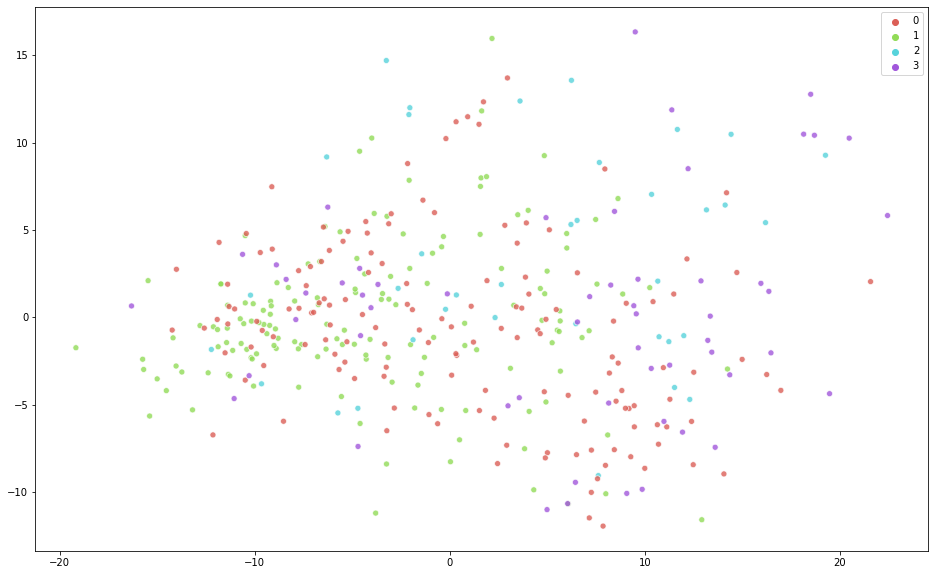

In [18]:
# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df_columns)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum:', sum(pca.explained_variance_ratio_))
## Explained variation per principal component: [0.1557712  0.11314638 0.08842925]

# Labels
y = [1] * NUM_TRAIN_SAMPLES[0] \
    + [2] * NUM_TEST_SAMPLES[0] \
    + [0] * NUM_TRAIN_SAMPLES[1] \
    + [3] * NUM_TEST_SAMPLES[1]

# Plot: 3d
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y, 
    cmap='jet',
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Plot: 2d
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue=y,
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)

# Audio Data Augmentation

## Imports

In [ ]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt

## Extract Synchronized Events from Audio/EEG Data

In [8]:
def to_eeg_index(audio_index):
    return int(audio_index / AUDIO_SAMPLE_FREQ * SAMPLE_FREQ)

END = to_eeg_index(INTERVAL * AUDIO_SAMPLE_FREQ) # Produce training samples of uniform length.
df_columns = np.empty((0, int(END * N_COMPONENTS)))
data_stack = np.empty((0, END, N_COMPONENTS))

NUM_SAMPLES = []

for l in label:
    print(l)
    event_cts = 0
    for trial in train_number:
        print('####', end=' ')
        ### READ AUDIO DATA
        audio_path = audio_root + audio_prefix + l + str(trial) + audio_suffix
        _, samples = wavfile.read(audio_path)
        envelope = np.abs(signal.hilbert(samples))
        
        ### GET AUDIO EVENTS
        events = np.empty((0, 2))
        in_event = False
        new_event = np.zeros((1, 2))
        hi_threshold_check = False
        for s in range(len(samples)):
            if (not in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_LO):
                in_event = True
                new_event[0][0] = s
            elif (in_event) and (envelope[s] < AUDIO_EVENT_THRESHOLD_LO):
                in_event = False
                new_event[0][1] = s
                event_length = new_event[0][1] - new_event[0][0]
                if hi_threshold_check and event_length >= MIN_AUDIO_EVENT_LENGTH:
#                     print(new_event[0][1] - new_event[0][0], end=' ') # Verbose Progress bar
                    print('*', end='') # Simplified progress bar
                    events = np.concatenate((events, new_event), axis=0)
                    hi_threshold_check = False
            elif (in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_HI):
                hi_threshold_check = True

        ### READ EEG DATA
        cortical_path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(cortical_path)
        
        
#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:])
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.

        ### EXTRACT EEG EVENTS FROM AUDIO EVENTS
        cts = 0
        for e in events:
            cts += 1
            event_cts += 1
            
            START = to_eeg_index(e[0])

            raw = df.iloc[START:]
            if (raw.equals(raw.dropna()) == False):
                # print('Dropped NaN: %s%d, sample %d' %(l, trial, ct))
                raw = raw.dropna()
            raw = raw.iloc[:END]
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, END, N_COMPONENTS)) # Split into N_COMPONENTS channels
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
            
            df_col = np.reshape(
                raw_vals, (1, int(END * N_COMPONENTS))) # One vector of df_stack
            df_columns = np.concatenate((df_columns, df_col), axis=0)
            
        print('*' + str(cts), end=' ') # Progress bar
        
    NUM_SAMPLES = NUM_SAMPLES + [event_cts]
    print('\n')

df_stack = pd.DataFrame(df_columns) # Will only work when data is combined.
# print(df_stack.head())
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

# Labels: 1=GO, 0=STOP
data_labels = [1] * NUM_SAMPLES[0] + [0] * NUM_SAMPLES[1]
print(NUM_SAMPLES)

GO_
#### ***********************************************************************************82 #### **********************************************************************69 #### ************************************35 

STOP_
#### ****************************************************************************75 #### ***************************************************************************************86 #### **********************************************45 

       0         1         2         3         4         5         6     \
0  0.728232  0.577538  0.673247  0.634019  0.798853  0.418201  0.301199   
1  0.728232 -0.025889  0.506113  0.634019  0.798853  0.004362  0.116127   
2  0.099483 -0.583032  0.139778  0.342210  0.280243 -0.451637 -0.170407   
3  0.393336 -0.441722 -0.093322  0.654700  0.266842 -0.467656 -0.325498   
4  1.024148 -0.045052  0.374077  0.998079  0.835364 -0.289161 -0.061546   

       7         8         9     ...      2030      2031      2032      2033  \
0  0.7139

### Split Data into Train/Test Sets

In [34]:
NUM_TRAIN_SAMPLES = [150, 150]
NUM_TEST_SAMPLES = [36, 56]

# train_df = df_stack.iloc[np.r_[
#     0:NUM_TRAIN_SAMPLES[0], 
#     NUM_SAMPLES[0]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]]]
# test_df = df_stack.iloc[np.r_[
#     NUM_TRAIN_SAMPLES[0]:NUM_SAMPLES[0],
#     NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]:NUM_SAMPLES[0]+NUM_SAMPLES[1]]]
# train_stack = train_df.values
# test_stack = test_df.values

train_stack = data_stack[np.r_[
    0:NUM_TRAIN_SAMPLES[0], 
    NUM_SAMPLES[0]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]], :, :]
test_stack = data_stack[np.r_[
    NUM_TRAIN_SAMPLES[0]:NUM_TRAIN_SAMPLES[0]+NUM_TEST_SAMPLES[0],
    NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]+NUM_TEST_SAMPLES[1]], :, :]
print(train_stack.shape, test_stack.shape)

train_data = np.split(train_stack, N_COMPONENTS, axis=2)
test_data = np.split(test_stack, N_COMPONENTS, axis=2)
print(len(train_data), train_data[0].shape)
print(len(test_data), test_data[0].shape)

# Labels: 1=GO, 0=STOP
train_labels = np.asarray([1] * NUM_TRAIN_SAMPLES[0] + [0] * NUM_TRAIN_SAMPLES[1])
test_labels = np.asarray([1] * NUM_TEST_SAMPLES[0] + [0] * NUM_TEST_SAMPLES[1])
print(train_labels.shape, test_labels.shape)

(300, 102, 20) (92, 102, 20)
20 (300, 102, 1)
20 (92, 102, 1)
(300,) (92,)


## Read and Plot Audio Data

sound_2/STOP_1.wav


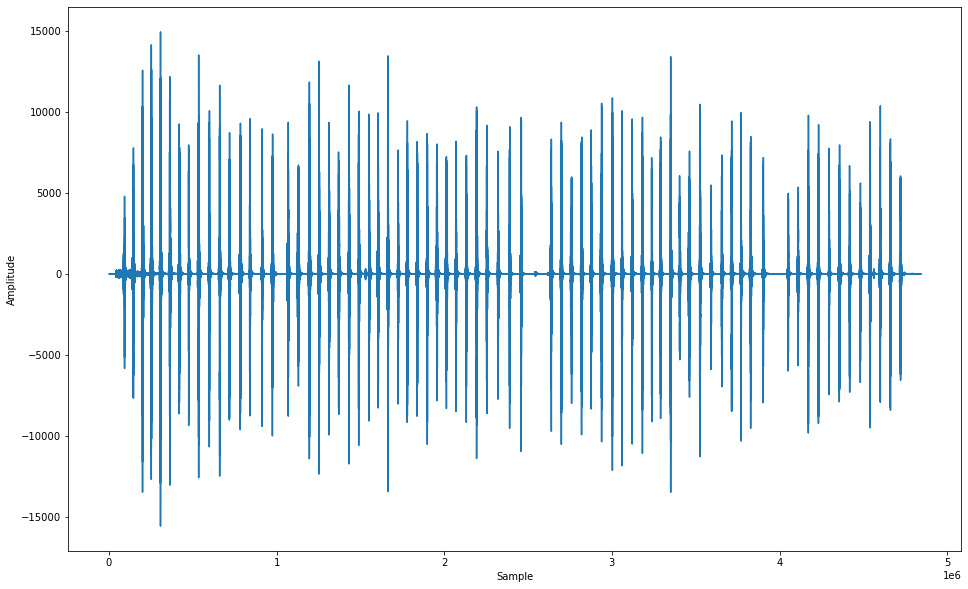

In [6]:
audio_path = audio_root + audio_prefix + label[1] + str(1) + audio_suffix
print(audio_path)
sample_rate, samples = wavfile.read(audio_path)
plt.figure(figsize=(16,10))
plt.plot(samples[:], )
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.show()

## Extract Events from Audio Data

In [ ]:
AUDIO_EVENT_THRESHOLD_LO = 1
AUDIO_EVENT_THRESHOLD_HI = 1000
AUDIO_PLT_LEFT, AUDIO_PLT_RIGHT = 0, len(envelope)
envelope = np.abs(signal.hilbert(samples))
threshold_lo = np.ones(len(envelope)) * AUDIO_EVENT_THRESHOLD_LO
threshold_hi = np.ones(len(envelope)) * AUDIO_EVENT_THRESHOLD_HI

plt.figure(figsize=(16,10))
plt.xlabel('Sample Coordinate'); plt.ylabel('Amplitude')
plt.plot(samples[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='raw')
plt.plot(envelope[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='envelope')
plt.plot(threshold_lo[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='threshold_lo')
plt.plot(threshold_hi[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='threshold_hi')

plt.show()

events = np.empty((0, 2))
in_event = False
new_event = np.zeros((1, 2))
hi_threshold_check = False

for s in range(len(samples)):
    if (not in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_LO):
        in_event = True
        new_event[0][0] = s
    elif (in_event) and (envelope[s] < AUDIO_EVENT_THRESHOLD_LO):
        in_event = False
        new_event[0][1] = s
        if hi_threshold_check:
            events = np.concatenate((events, new_event), axis=0)
            hi_threshold_check = False
    elif (in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_HI):
        hi_threshold_check = True

print(events, len(events))

for e in events:
    print(e[1]-e[0])

# Inference via KNN in PCA Space

## Imports

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Embed Sample into PCA Space

In [ ]:
def embed_pca(raw_eeg, pca_components):
    """
    Embeds RAW_EEG into the PCA representation space given by PCA_COMPONENTS
    """
    return np.dot(pca_components, raw_eeg.T).T

In [ ]:
train_stack_pca = embed_pca(train_stack, pca.components_)
print(train_stack_pca.shape)
test_stack_pca = embed_pca(test_stack, pca.components_)
print(test_stack_pca.shape)

### Playground: Embedding one sample into PCA Space

In [ ]:
# Procedure for obtaining one sample's representation in PCA space
sample = data_stack[0,:]
print(sample.shape)
sample_rep = np.dot(pca_components, sample)

## KNN Classifier

### Playground: Test Different k-values

In [ ]:
k_range = range(1, 51)
scores_list = []
TEST_TO_TRAIN_WEIGHT = 5
total_stack_pca = np.concatenate(
    (np.tile(test_stack_pca,
             (TEST_TO_TRAIN_WEIGHT, 1)),
     train_stack_pca))
total_labels = np.concatenate(
    (np.tile(test_labels,
             (TEST_TO_TRAIN_WEIGHT)),
     train_labels))
print(total_stack_pca.shape)
print(total_labels.shape)
for k_val in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(train_stack_pca, train_labels)
    knn_predict = knn.predict(test_stack_pca)
    scores_list.append(metrics.accuracy_score(test_labels, knn_predict))

print('Maximum accuracy is %f' % (np.amax(scores_list)))

### Plot KNN Results

In [ ]:
sns.lineplot(x=k_range, y=scores_list)

# Neural Network Approaches

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Read in Data to tf.data.Dataset

### Read into Numpy Array

#### Training Data

In [ ]:
train_root = 'csvc/'
test_root = 'csvc/'
train_number = range(1, 6)
test_number = range(6, 9)

In [ ]:
data_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
# print(data_stack.shape)

for l in label:
    for trial in train_number:
        path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
#         print(df.shape)

        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
#         print(data_stack.shape)
        
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

#### Testing

In [ ]:
test_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
for l in label:
    for trial in test_number:
        path = test_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
            test_stack = np.concatenate((test_stack, raw_vals), axis=0)
#             print(test_stack.shape)
# df_test = pd.DataFrame(test_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("test_stack shape: ", test_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(test_stack))) == 0)  # Should be empty

#### Labels

In [ ]:
# Labels
train_labels = np.concatenate(
    (np.tile([0, 1], (NUM_TRAIN_SAMPLES[0], 1)), # GO
     np.tile([1, 0], (NUM_TRAIN_SAMPLES[1], 1))) # STOP
)
test_labels = np.concatenate(
    (np.tile([0, 1], (NUM_TEST_SAMPLES[0], 1)), # GO
     np.tile([1, 0], (NUM_TEST_SAMPLES[1], 1))) # STOP
)
# [0 1]=GO, [1 0]=STOP

### Create tf.data.Dataset from tensor slices

In [4]:
FULL_DATASET_SIZE = NUM_TRAIN_SAMPLES[0] + NUM_TRAIN_SAMPLES[1]
TRAIN_SIZE = int(FULL_DATASET_SIZE * 0.8)
VALIDATION_SIZE = int(FULL_DATASET_SIZE * 0.2)

TRAIN_BATCH_SIZE = 1
VALIDATION_BATCH_SIZE = 1

full_dataset = tf.data.Dataset.from_tensor_slices(
    (train_stack, train_labels)
).shuffle(FULL_DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE).batch(TRAIN_BATCH_SIZE)
validation_dataset = full_dataset.skip(TRAIN_SIZE).take(VALIDATION_SIZE).batch(VALIDATION_BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_stack, test_labels))
TEST_SHUFFLE_BUFFER = NUM_TEST_SAMPLES[0] + NUM_TEST_SAMPLES[1]
TEST_BATCH_SIZE = 1
test_dataset = test_dataset.shuffle(TEST_SHUFFLE_BUFFER).batch(TEST_BATCH_SIZE)

In [5]:
print(train_dataset, validation_dataset, test_dataset)

<BatchDataset shapes: ((None, 102, 20), (None,)), types: (tf.float64, tf.int32)> <BatchDataset shapes: ((None, 102, 20), (None,)), types: (tf.float64, tf.int32)> <BatchDataset shapes: ((None, 102, 20), (None,)), types: (tf.float64, tf.int32)>


## Build the Model with Keras

### A Basic Convolutional Neural Network

In [ ]:
input_shape = (int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS, 1)
raw_shape = (2040, 1)
inputs = keras.Input(shape=raw_shape)
# A proposed architecture is to use recurrent first to "summarize,"
    # No need for embedding layer in recurrent subnetwork?
# then use convolutional to classify.

# reshape
reshape = layers.Reshape((int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS, 1), input_shape=raw_shape)
first_conv = layers.Conv2D(16, 3, activation='relu')
first_pool = layers.MaxPool2D(pool_size=(2, 1))
second_conv = layers.Conv2D(32, 3, activation='relu')
second_pool = layers.MaxPool2D(pool_size=(2, 1))
third_conv = layers.Conv2D(64, 3, activation='relu')
flattener = layers.Flatten()
first_dense = layers.Dense(64, activation='relu')
second_dense = layers.Dense(16, activation='relu')
third_dense = layers.Dense(2)

outputs = third_dense(
    second_dense(first_dense(
        flattener(
            third_conv(
                second_pool(second_conv(
                    first_pool(first_conv(reshape(inputs))))))))))

model = keras.Model(inputs=inputs, outputs=outputs, name='simple_conv')
model.summary()

### A Basic Recurrent Neural Network

In [ ]:
input_shape = (int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS)
raw_shape = (2040,1)
inputs = keras.Input(shape=raw_shape)

reshape = layers.Reshape(input_shape, input_shape=raw_shape)
recurr_layer = layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1)
first_dense = layers.Dense(64, activation='sigmoid')
result_dense = layers.Dense(2, activation='sigmoid')

outputs = result_dense(
        first_dense(
            recurr_layer(reshape(inputs))))

model = keras.Model(inputs=inputs, outputs=outputs, name='simple_lstm')
model.summary()

### A Multi-Channel Recurrent-->Dense Neural Network

In [20]:
sg_ch_input_shape = (END, 1)
LSTM_REDUCE_DIM = N_COMPONENTS

channel_inputs, recurr_layers = [], []
for ch in range(N_COMPONENTS):
    channel_inputs = channel_inputs + [keras.Input(shape=sg_ch_input_shape)]
    recurr_layers = recurr_layers + [layers.LSTM(LSTM_REDUCE_DIM)(channel_inputs[ch])]
    
recurr_outs = layers.concatenate(recurr_layers)
first_dense = layers.Dense(64, activation='tanh')(recurr_outs)
dropout = layers.Dropout(0.1)(first_dense)
output = layers.Dense(1, activation='sigmoid')(dropout)

model = keras.Model(inputs=channel_inputs, outputs=output)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 102, 1)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 102, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 102, 1)]     0                                            
______________________________________________________________________________________________

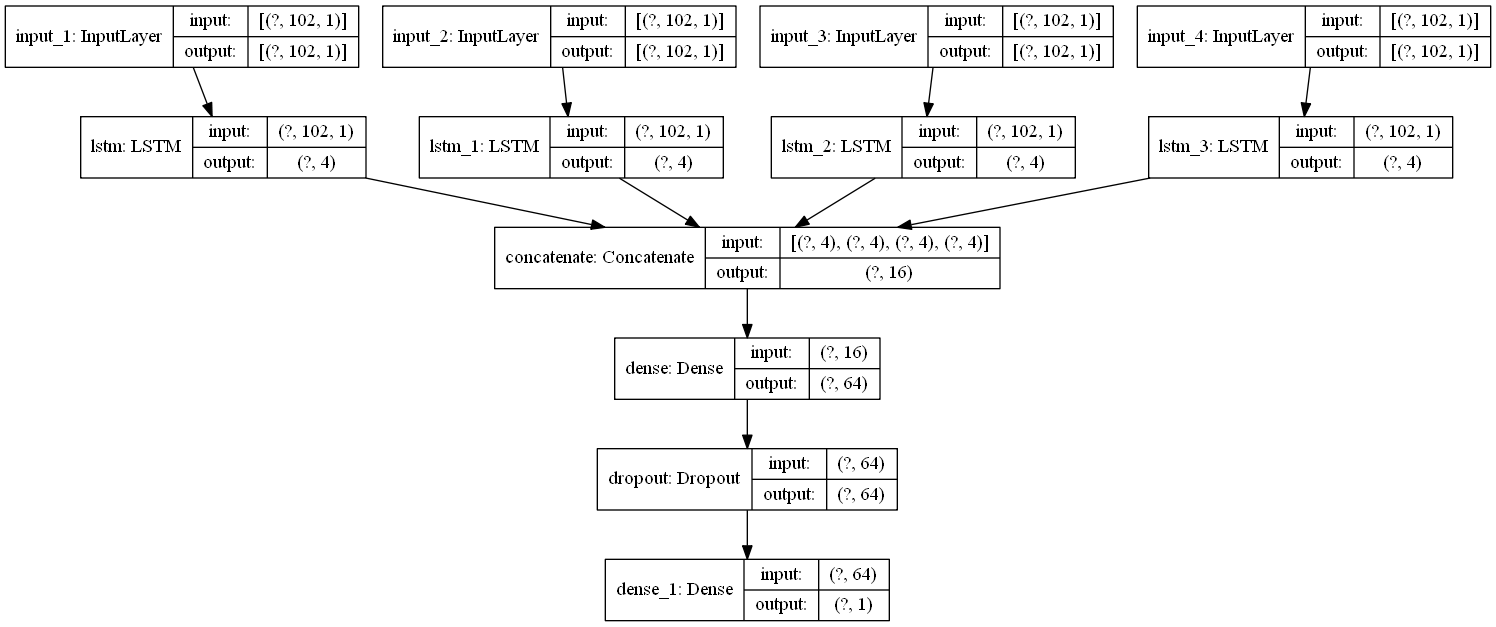

In [6]:
keras.utils.plot_model(model, 'multi-channel_recurrent.png', show_shapes=True)

### A Recurrent-->Convolutional Neural Network

In [ ]:
sg_ch_input_shape = (END, 1)
LSTM_REDUCE_DIM = N_COMPONENTS

channel_inputs, recurr_layers = [], []
for ch in range(N_COMPONENTS):
    channel_inputs = channel_inputs + [keras.Input(shape=sg_ch_input_shape)]
    recurr_layers = recurr_layers + [layers.LSTM(LSTM_REDUCE_DIM)(channel_inputs[ch])]
    
recurr_outs = layers.concatenate(recurr_layers) # reshape?
first_conv = layers.Conv2D(16, 3, activation='relu')(recurr_outs) 
first_pool = layers.MaxPool2D(pool_size=(2, 1))
second_conv = layers.Conv2D(32, 3, activation='relu')
second_pool = layers.MaxPool2D(pool_size=(2, 1))
first_dense = layers.Dense(64, activation='tanh')(recurr_outs)
dropout = layers.Dropout(0.1)(first_dense)
output = layers.Dense(1, activation='sigmoid')(dropout)

model = keras.Model(inputs=channel_inputs, outputs=output)

### Compile Model

In [22]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10, verbose=1, validation_data=validation_dataset)

In [23]:
history = model.fit(train_data, train_labels, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
38/38 [==============================] - 3s 71ms/step - loss: 0.6975 - accuracy: 0.5000
Epoch 2/10
38/38 [==============================] - 3s 67ms/step - loss: 0.6799 - accuracy: 0.5567
Epoch 3/10
38/38 [==============================] - 3s 66ms/step - loss: 0.6625 - accuracy: 0.6067
Epoch 4/10
38/38 [==============================] - 3s 68ms/step - loss: 0.6427 - accuracy: 0.6667
Epoch 5/10
38/38 [==============================] - 3s 67ms/step - loss: 0.6282 - accuracy: 0.7000
Epoch 6/10
38/38 [==============================] - 3s 67ms/step - loss: 0.6278 - accuracy: 0.7233
Epoch 7/10
38/38 [==============================] - 3s 66ms/step - loss: 0.6064 - accuracy: 0.7700
Epoch 8/10
38/38 [==============================] - 3s 67ms/step - loss: 0.5983 - accuracy: 0.8267
Epoch 9/10
38/38 [==============================] - 3s 66ms/step - loss: 0.5902 - accuracy: 0.8200
Epoch 10/10
38/38 [==============================] - 3s 67ms/step - loss: 0.5887 - accuracy: 0.8167


## Test Model

In [24]:
test_loss, test_acc = model.evaluate(test_data, test_labels)

3/3 [==============================] - 0s 33ms/step - loss: 0.6315 - accuracy: 0.7222


In [38]:
test_output = model.predict(test_data)
round_test_out = list(map(np.round, np.concatenate(test_output)))

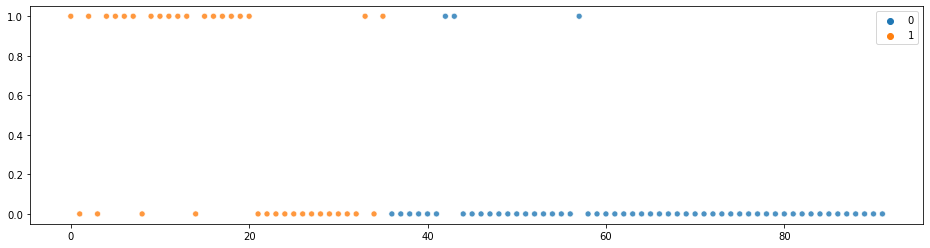

In [45]:
plt.figure(figsize=(16,4))
sns.scatterplot(x=range(len(round_test_out)),
                y=round_test_out,
                hue=test_labels,
                alpha=0.8)